https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb

# Dependencies

In [1]:
!pip install tensorflow==1.15

In [2]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv1D, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


# GAN

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 128
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    
    def build_generator(self):
        model = Sequential()
        #model.add(Dense(256, input_dim=self.latent_dim))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(1024))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(2*2*512, input_shape=(self.latent_dim,)))
        model.add(Reshape((2, 2, 512)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Conv2D(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        
    def build_discriminator(self):
        model = Sequential()
        #model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(1, activation='sigmoid'))

        model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(self.img_shape)))
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))



        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = cifar10.load_data()
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
               self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

# Train

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=64, sample_interval=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_______________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.556528, acc.: 40.62%] [G loss: 0.001616]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
5001 [D loss: 0.000499, acc.: 100.00%] [G loss: 7.637511]
5002 [D loss: 0.000163, acc.: 100.00%] [G loss: 6.992756]
5003 [D loss: 0.000879, acc.: 100.00%] [G loss: 7.658617]
5004 [D loss: 0.000899, acc.: 100.00%] [G loss: 7.525787]
5005 [D loss: 0.000701, acc.: 100.00%] [G loss: 8.173836]
5006 [D loss: 0.010370, acc.: 100.00%] [G loss: 5.128771]
5007 [D loss: 0.001720, acc.: 100.00%] [G loss: 6.574634]
5008 [D loss: 0.001976, acc.: 100.00%] [G loss: 8.659726]
5009 [D loss: 0.000168, acc.: 100.00%] [G loss: 8.289399]
5010 [D loss: 0.000207, acc.: 100.00%] [G loss: 8.916573]
5011 [D loss: 0.000146, acc.: 100.00%] [G loss: 8.398762]
5012 [D loss: 0.000138, acc.: 100.00%] [G loss: 8.655685]
5013 [D loss: 0.000230, acc.: 100.00%] [G loss: 8.513594]
5014 [D loss: 0.000325, acc.: 100.00%] [G loss: 8.456451]
5015 [D loss: 0.000651, acc.: 100.00%] [G loss: 8.748124]
5016 [D loss: 0.000828, acc.: 100.00%] [G loss: 7.818780]
5017 [D loss: 0.00021

# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

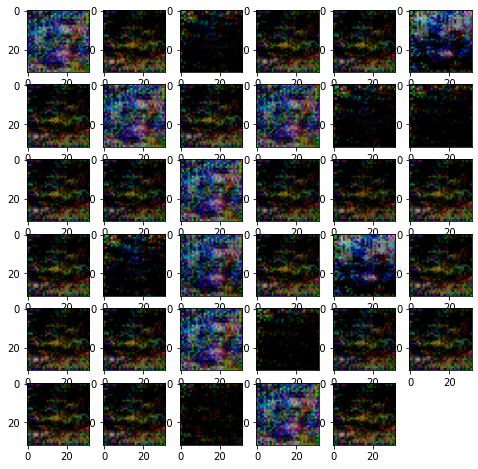

In [5]:
noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


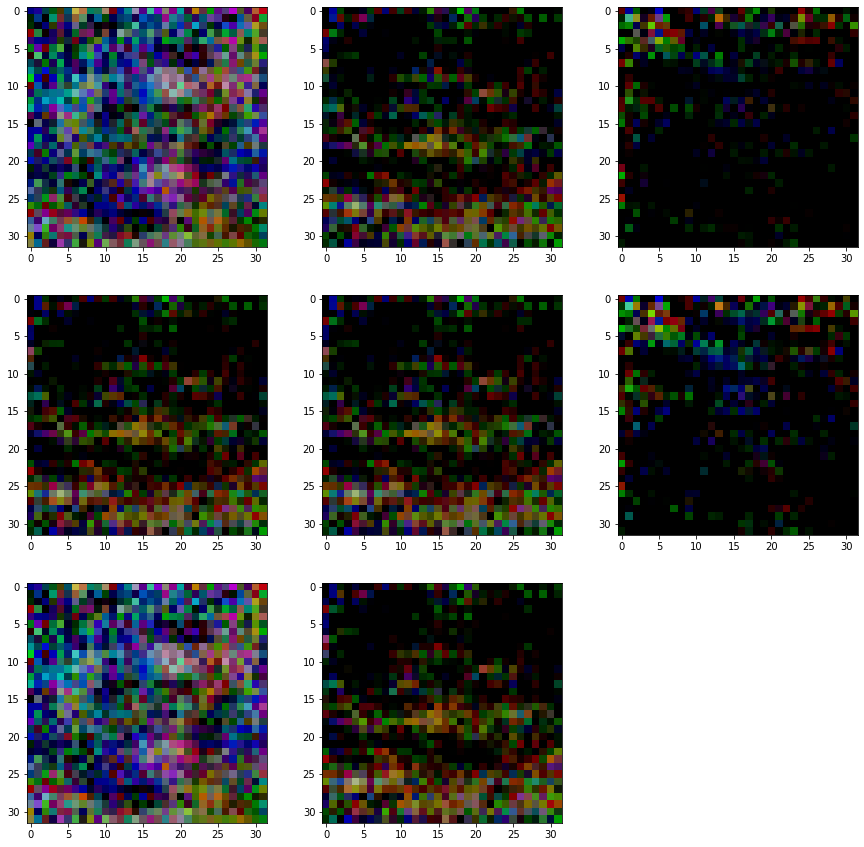

In [6]:
noise = np.random.normal(0, 1, (9,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

# Extra

In [ ]:
class GAN():
  def __init__(self):
    self.img_rows = 32
    self.img_cols = 32
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 128
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    z = Input(shape=(self.latent_dim,))

    img  = self.generator(z)

    self.discriminator.trainable = False

    validity = self.discriminator(img)
    self.combined = Model(z,validity)
    self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=optimizer)
    
  def build_generator(self):
    #functional code
    input_layer = Input(shape=(self.tf.expand_dims(self.latent_dim, axis = -1),))
    layer = Conv1D(4, 3)(input_layer)
    layer = Dense(256, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(512, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(1024, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)

    out1 = Dense(np.prod(self.img_shape), activation='tanh' )(layer)
    out1 = Reshape(self.img_shape)(out1)

    out2 =  Dense(1, activation='sigmoid' )(layer)

    noise = input_layer
    img = out1
    distance = out2

    model = Model(noise, img)
    model.summary()
    return model

        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)

  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = cifar10.load_data()
    
    Y_train = np_utils.to_categorical(y_train, num_classes)
    Y_test = np_utils.to_categorical(y_test, num_classes)
    X_train = np.float32(X_train)
    X_train = (X_train / 255 - 0.5) * 2
    X_train = np.clip(X_train, -1, 1)
    X_test = np.float32(X_test)
    X_test = (X_train / 255 - 0.5) * 2
    X_test = np.clip(X_test, -1, 1)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    #X_train = X_train / 127.5 - 1.
    #X_train = np.expand_dims(X_train, axis=3)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs, distances = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      real_data_discrimination = []
      for i in range(0,len(imgs)):
        real_data_discrimination.append(1/(np.linalg.norm(imgs[0]))) 
      real_data_discrimination = np.array(real_data_discrimination)

      g_loss = self.combined.train_on_batch(noise, [valid,real_data_discrimination])
      

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G loss: %f loss]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs, distances = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()